In [1]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo  
!pip install git+https://github.com/PyTorchLightning/pytorch-lightning
!pip uninstall opencv_python_headless -y
!pip install opencv-python-headless==4.1.2.30

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-9hfl7hup

  Cloning https://github.com/PyTorchLightning/pytorch-lightning to /tmp/pip-req-build-zooslhqd
  Running command git clone -q https://github.com/PyTorchLightning/pytorch-lightning /tmp/pip-req-build-zooslhqd
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 132 kB 5.7 MB/s 
     |████████████████████████████████| 332 kB 38.8 MB/s 
     |████████████████████████████████| 596 kB 41.2 MB/s 
     |████████████████████████████████| 1.1 MB 39.1 MB/s 
     |████████████████████████████████| 271 kB 50.6 MB/s 
     |████████████████████████████████| 192 kB 49.5 MB/s 
     |████████████████████████████████| 160 kB 45.2 MB/s 
  Created wheel for pytorch-lightning: filename=pytorch_lightning-1.6.0.dev0-py3-none-any.whl size=53

In [3]:
%cd /content/drive/MyDrive/20211/prj3/neoplasm-detection/unet-neo

/content/drive/MyDrive/20211/prj3/neoplasm-detection/unet-neo


In [4]:
from glob import glob

def get_all_image_name():
    path_images = glob('/content/drive/MyDrive/20211/prj3/data/train/train/*.jpeg')
    images_name_list = [i.split('/')[-1].split('.')[0] for i in path_images]
    return images_name_list 
images_name_list = get_all_image_name() 

path_img = '/content/drive/MyDrive/20211/prj3/data/train/train'
path_gt = '/content/drive/MyDrive/20211/prj3/data/train_gt/train_gt'
from data_loader import PolypDataset
import matplotlib.pyplot as plt

pl_dataset = PolypDataset(images_name_list, path_img, path_gt)

In [42]:
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from glob import glob
import os 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from model.neo_unet import NeoUNet
from model.loss import *
from data_loader import TestDataset 

list_image = []
def run_test_neo(model_path):

    device = torch.cuda if torch.cuda.is_available() else torch.device('cpu')
    model = NeoUNet()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

    train_loader = DataLoader(
        dataset=pl_dataset,
        batch_size=1, 
        num_workers=1,
        pin_memory=True
    )

    n_sample = 3 
    for idx, item in tqdm(enumerate(train_loader)):

        if idx > n_sample :
          break 
        image, image_id, size = item['image'],  item['id'] , item['size']

        h, w = size[0], size[1]
        with torch.no_grad():
            predict = model(image) # trả về một list do thằng F.interpolate upscale lên 
  
        predict = predict[3]  # lấy có thể lấy ra 0,1,2,3 -> nhưng 3 là cái rõ nhất (đầu ra )
        predict = F.upsample(predict, size=(h, w), mode='bilinear', align_corners=False)

        neo_predict = predict[:, [0], :, :]   # [0] get slice 
        non_predict = predict[:, [1], :, :]

        neo_predict = torch.sigmoid(neo_predict).squeeze().data.cpu().numpy()  # gpu-> cpu-> .numpy
        non_predict = torch.sigmoid(non_predict).squeeze().data.cpu().numpy()

        output = np.zeros(
            (predict.shape[-2], predict.shape[-1], 3)).astype(np.uint8)
        output[(neo_predict > non_predict) * (neo_predict > 0.5)] = [0, 0, 255]  # * is elemment wise 
        output[(non_predict > neo_predict) * (non_predict > 0.5)] = [0, 255, 0]
        
        # cv2.imwrite(os.path.join(save_path, f'{image_id[0]}.png'), output)
        image_path = os.path.join("/content/drive/MyDrive/20211/prj3/data/train/train", f'{image_id[0]}.jpeg')
        # print("path ",image_path)
        image = cv2.imread(image_path)[:,:,::-1]
        list_image.append(image)
        image_gt_path = os.path.join("/content/drive/MyDrive/20211/prj3/data/train_gt/train_gt", f'{image_id[0]}.jpeg')
        image_gt = cv2.imread(image_gt_path)[:,:,::-1]
        list_image.append(image_gt)
        list_image.append(output)

In [43]:
run_test_neo("/content/drive/MyDrive/20211/prj3/backup/neo_epoch147_loss0.09182.pth")

Using cache found in /root/.cache/torch/hub/PingoLH_Pytorch-HarDNet_master


ImageNet pretrained weights for HarDNet68 is loaded
Done load hardnet 68 


0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecat

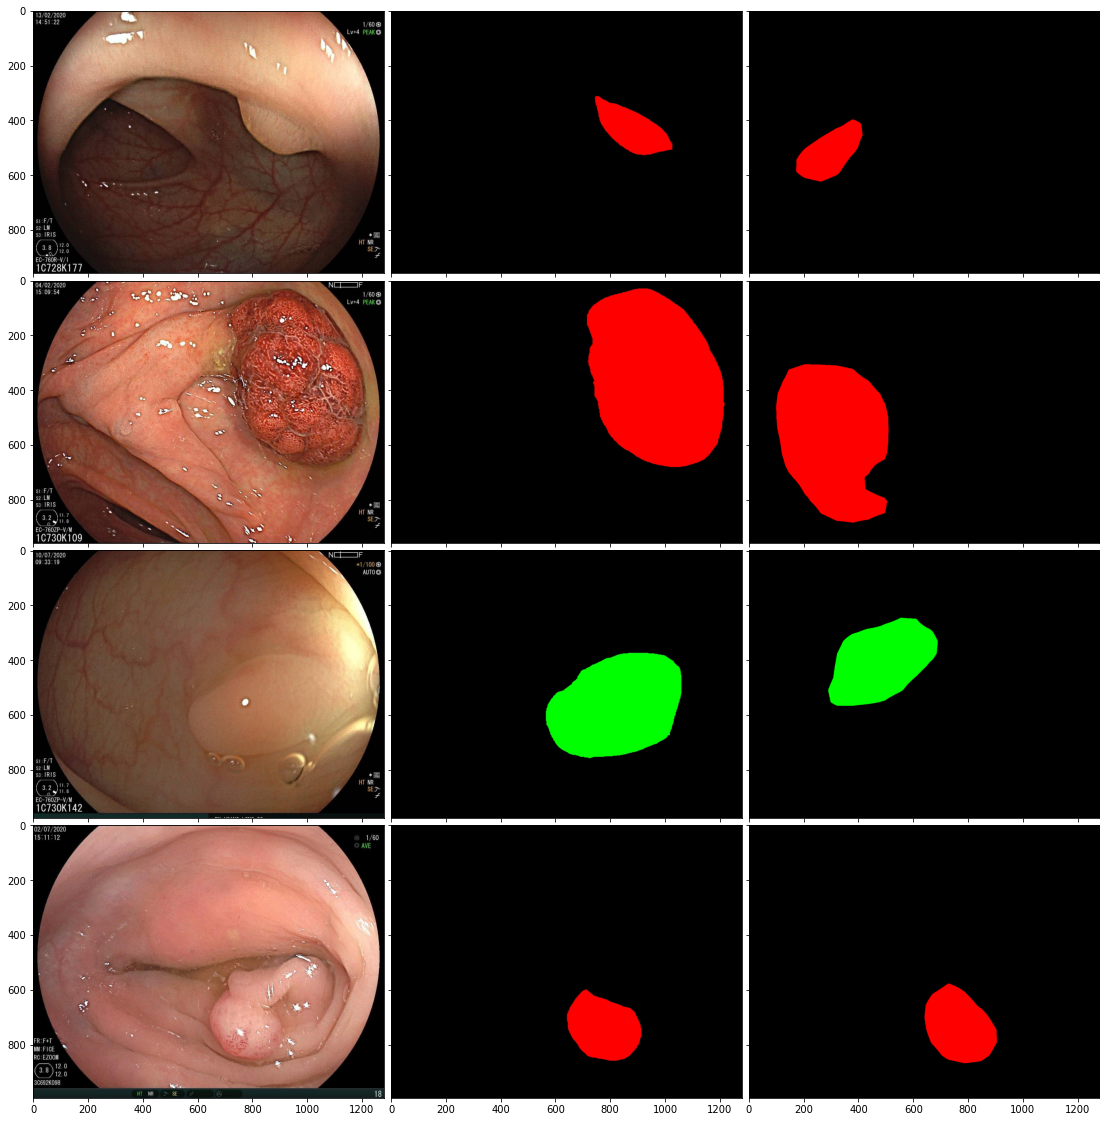

In [44]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(int(len(list_image)/3), 3),  
                 axes_pad=0.1,  # pad between axes
                 )
index = 0 
for ax, im in zip(grid, list_image):
    
    if index%3 == 2:
      im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    index = index +1
    ax.imshow(im)

plt.show()